# Clustering with BERT, UMAP, and HDBSCAN

In [2]:
import hdbscan
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt

Load messages.

In [3]:
messages = pd.read_csv('messages_100k.csv')
messages = messages['message'].tolist()

Get BERT embeddings.

In [4]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(messages, show_progress_bar=True)

In [5]:
embeddings.shape

(100000, 768)

Reduce dimensions with UMAP.

From the UMAP documentation: "we want a larger n_neighbors value – small values will focus more on very local structure and are more prone to producing fine grained cluster structure that may be more a result of patterns of noise in the data than actual clusters."

"Second it is beneficial to set min_dist to a very low value. Since we actually want to pack points together densely (density is what we want after all) a low value will help, as well as making cleaner separations between clusters."

In [85]:
n_neighbors = 40
n_components = 10
min_dist = 0

In [86]:
umapper = umap.UMAP(
    n_neighbors=n_neighbors, n_components=n_components, min_dist=min_dist, metric='cosine')
umap_embeddings = umapper.fit_transform(embeddings)

In [87]:
umap_embeddings.shape

(100000, 10)

Cluster with HDBSCAN.

In [88]:
min_cluster_size = 50

In [89]:
hdbscanner = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom')
cluster = hdbscanner.fit(umap_embeddings)

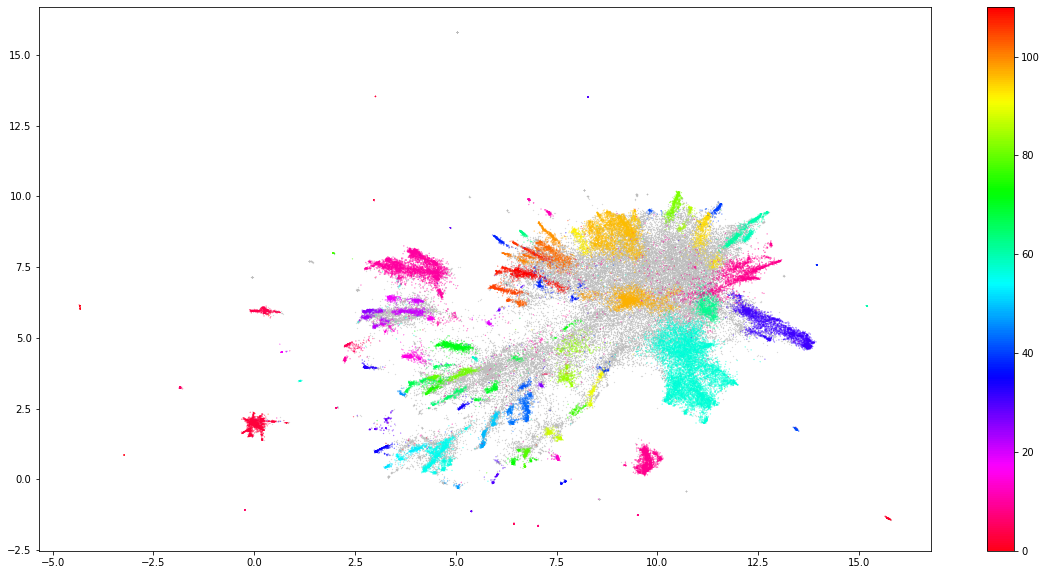

In [90]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(
    embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar();

In [91]:
docs_df = pd.DataFrame(messages, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [92]:
docs_per_topic.head()

Topic                                                Doc
0     -1  Is the offer still available of 6 weeks free a...
1      0  null, reduce pain, anxiety , inflammation with...
2      1  Hi I'm Kayla! Are there any upcoming or ongoin...
3      2  Hi I'm Michael! Are there any upcoming or ongo...
4      3  Hi, I'm Jena. I am interested in Unit 10306 or...

Number of topics.

In [93]:
np.unique(cluster.labels_).shape[0]

112

Get topic sizes.

In [94]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [95]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [96]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(messages))

In [97]:
tf_idf.shape

(37253, 112)

In [98]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [99]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [100]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)

In [101]:
topic_sizes.head(15)

Topic   Size
0       -1  48356
58      57   9063
11      10   4642
10       9   4369
97      96   3032
32      31   2722
4        3   1800
98      97   1683
56      55   1271
72      71   1139
103    102    872
63      62    791
5        4    669
83      82    658
44      43    649

Display topic words for top topics.

In [102]:
num_top_topics = 10

In [103]:
from wordcloud import WordCloud

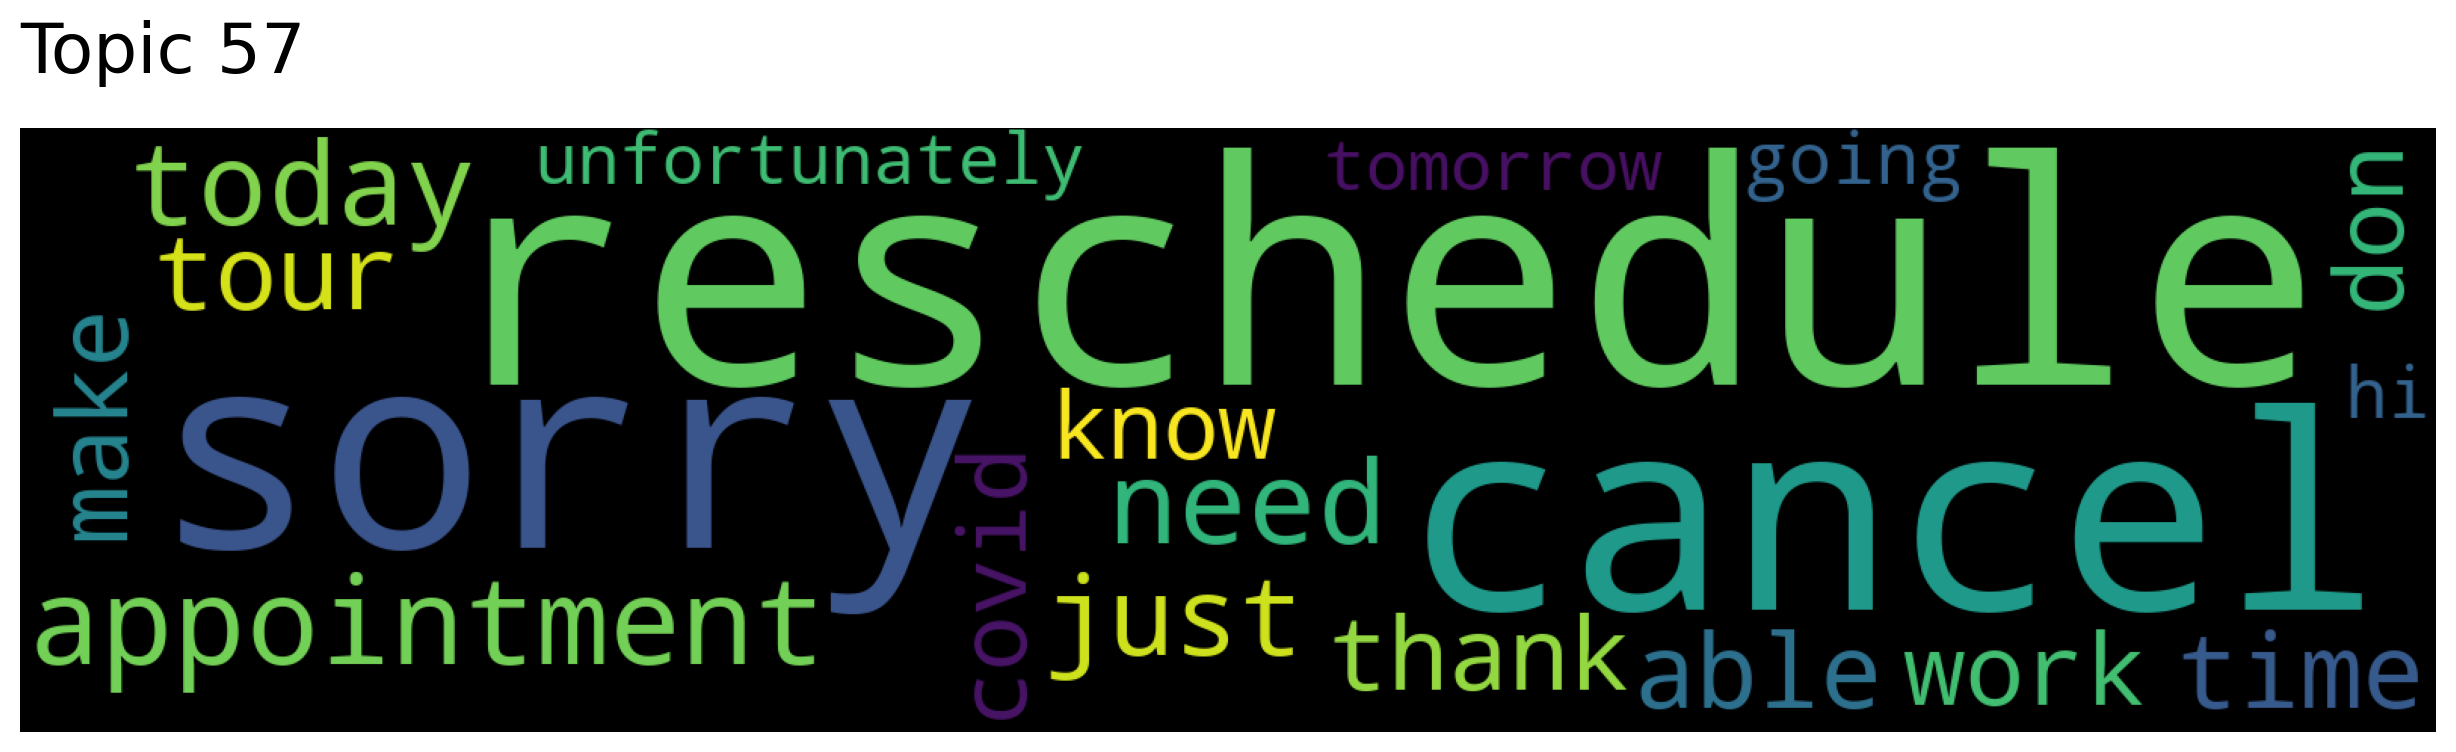

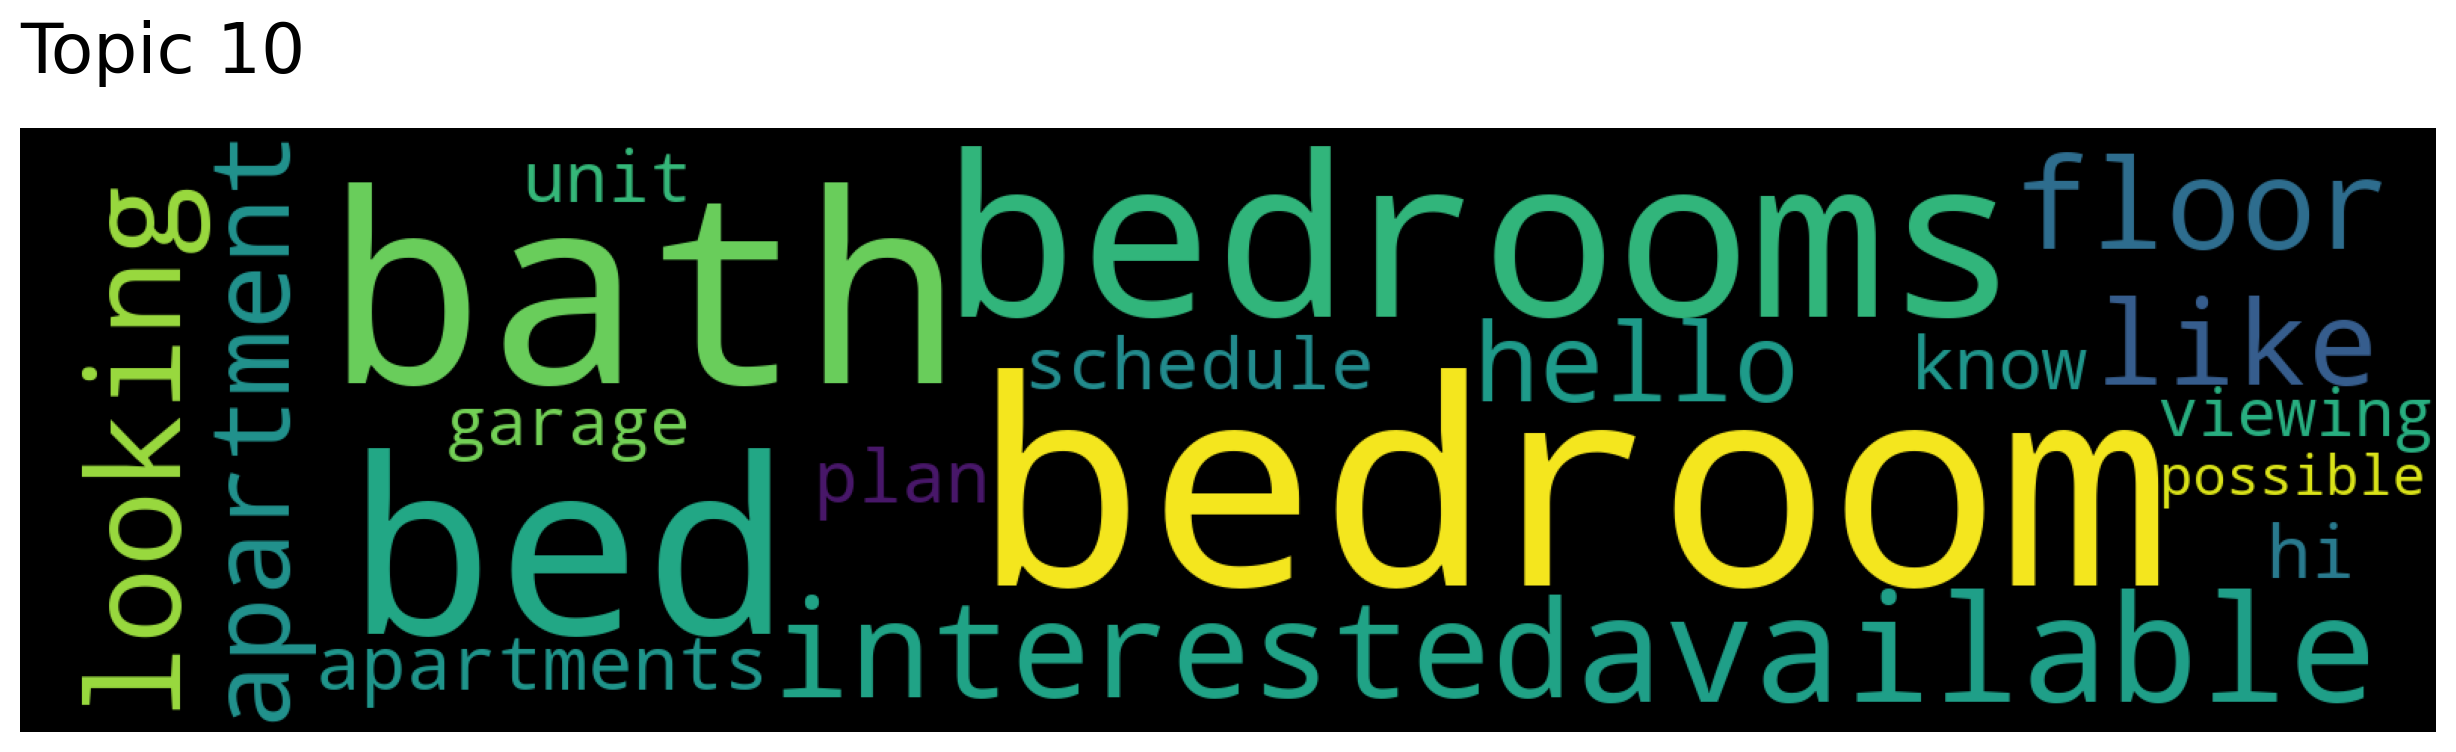

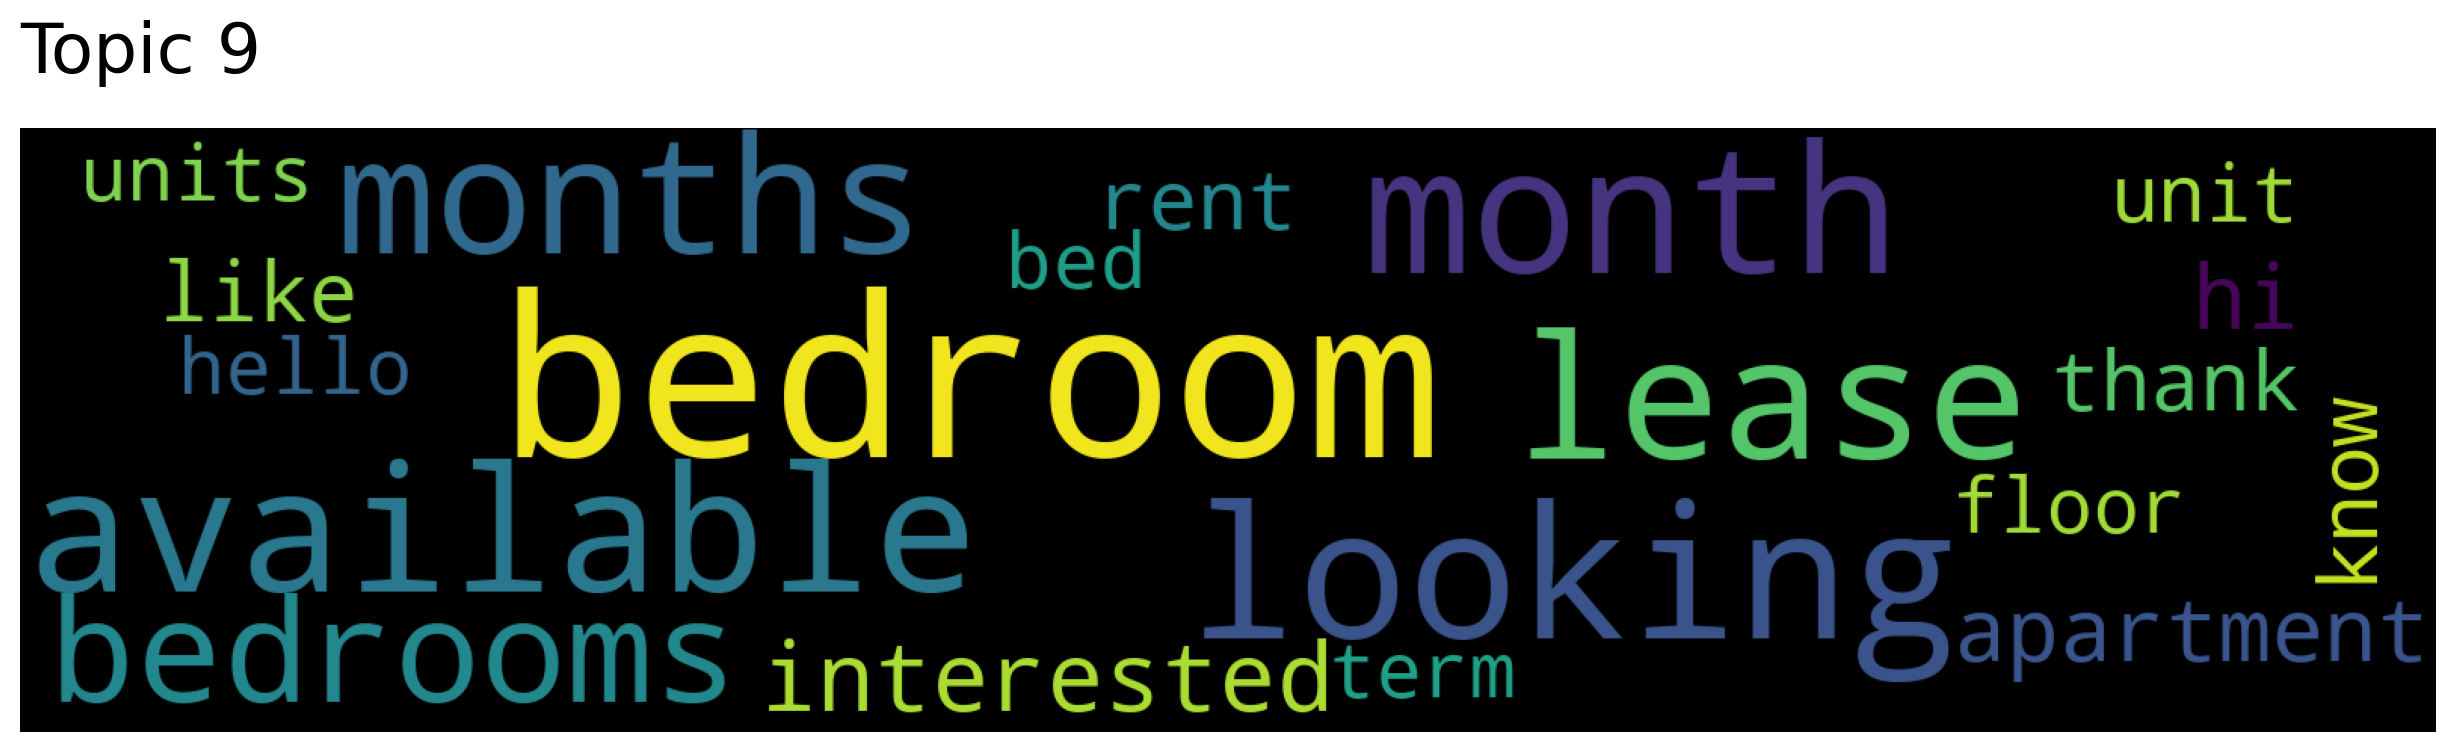

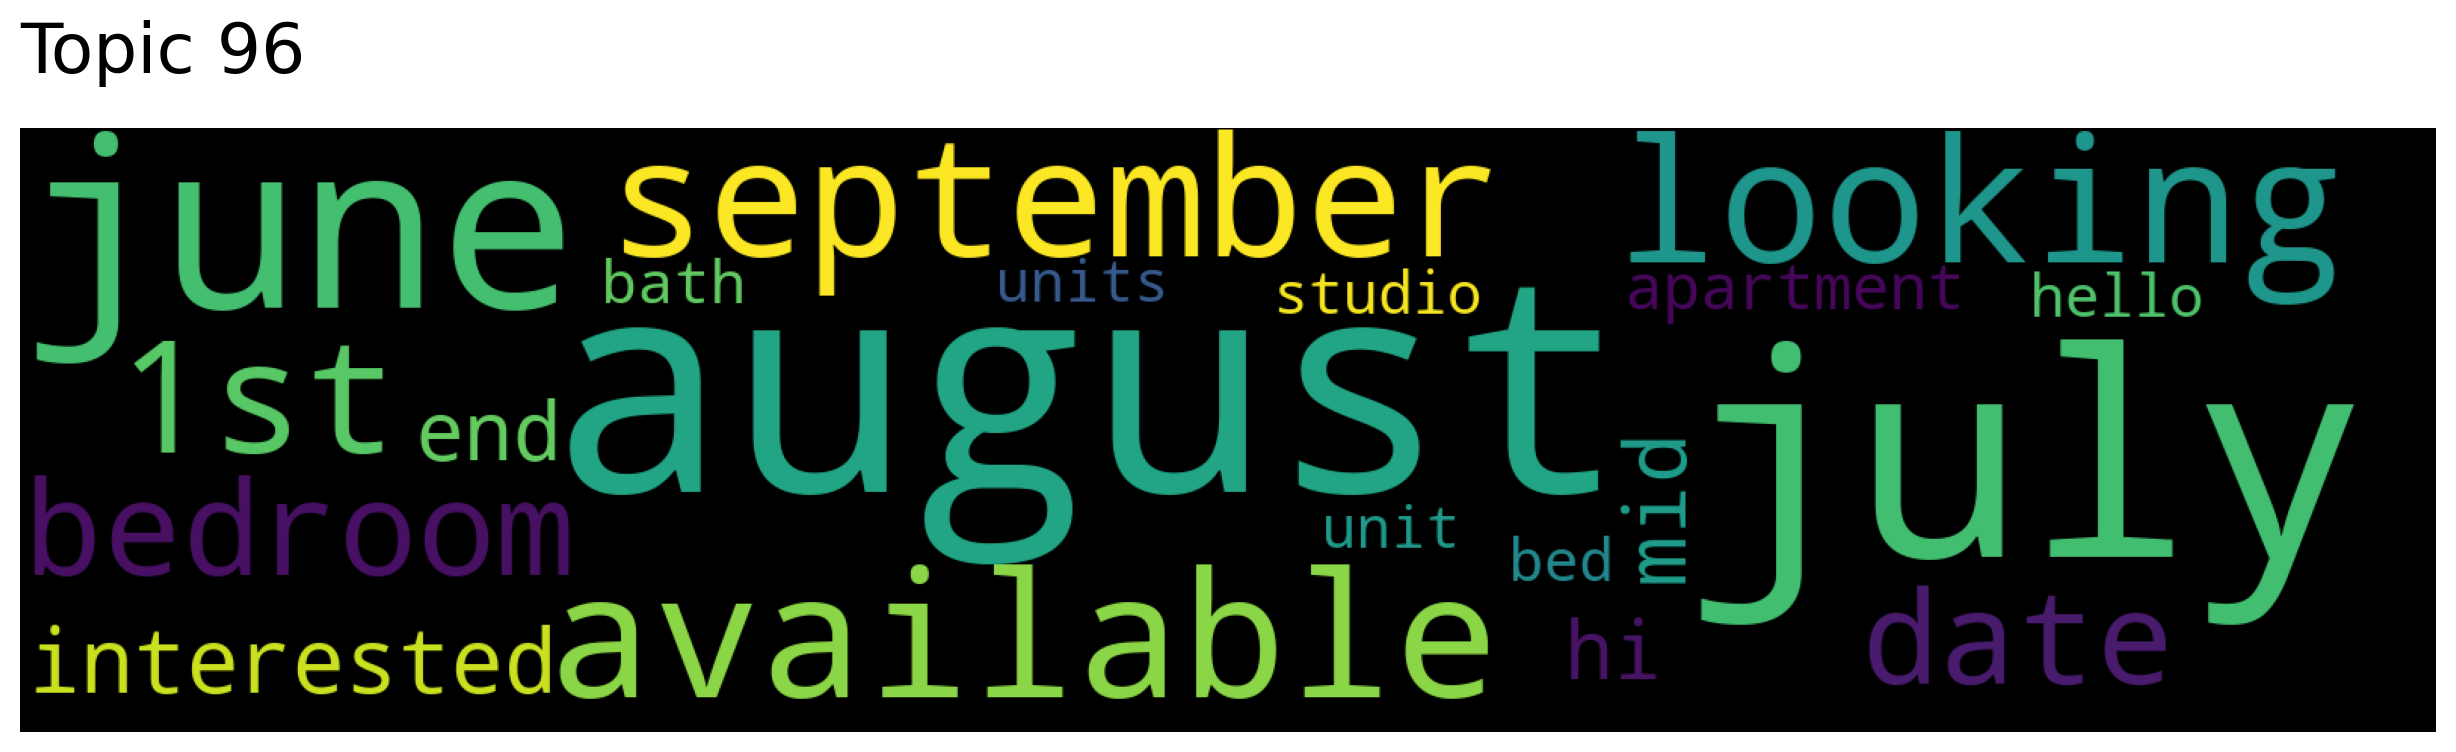

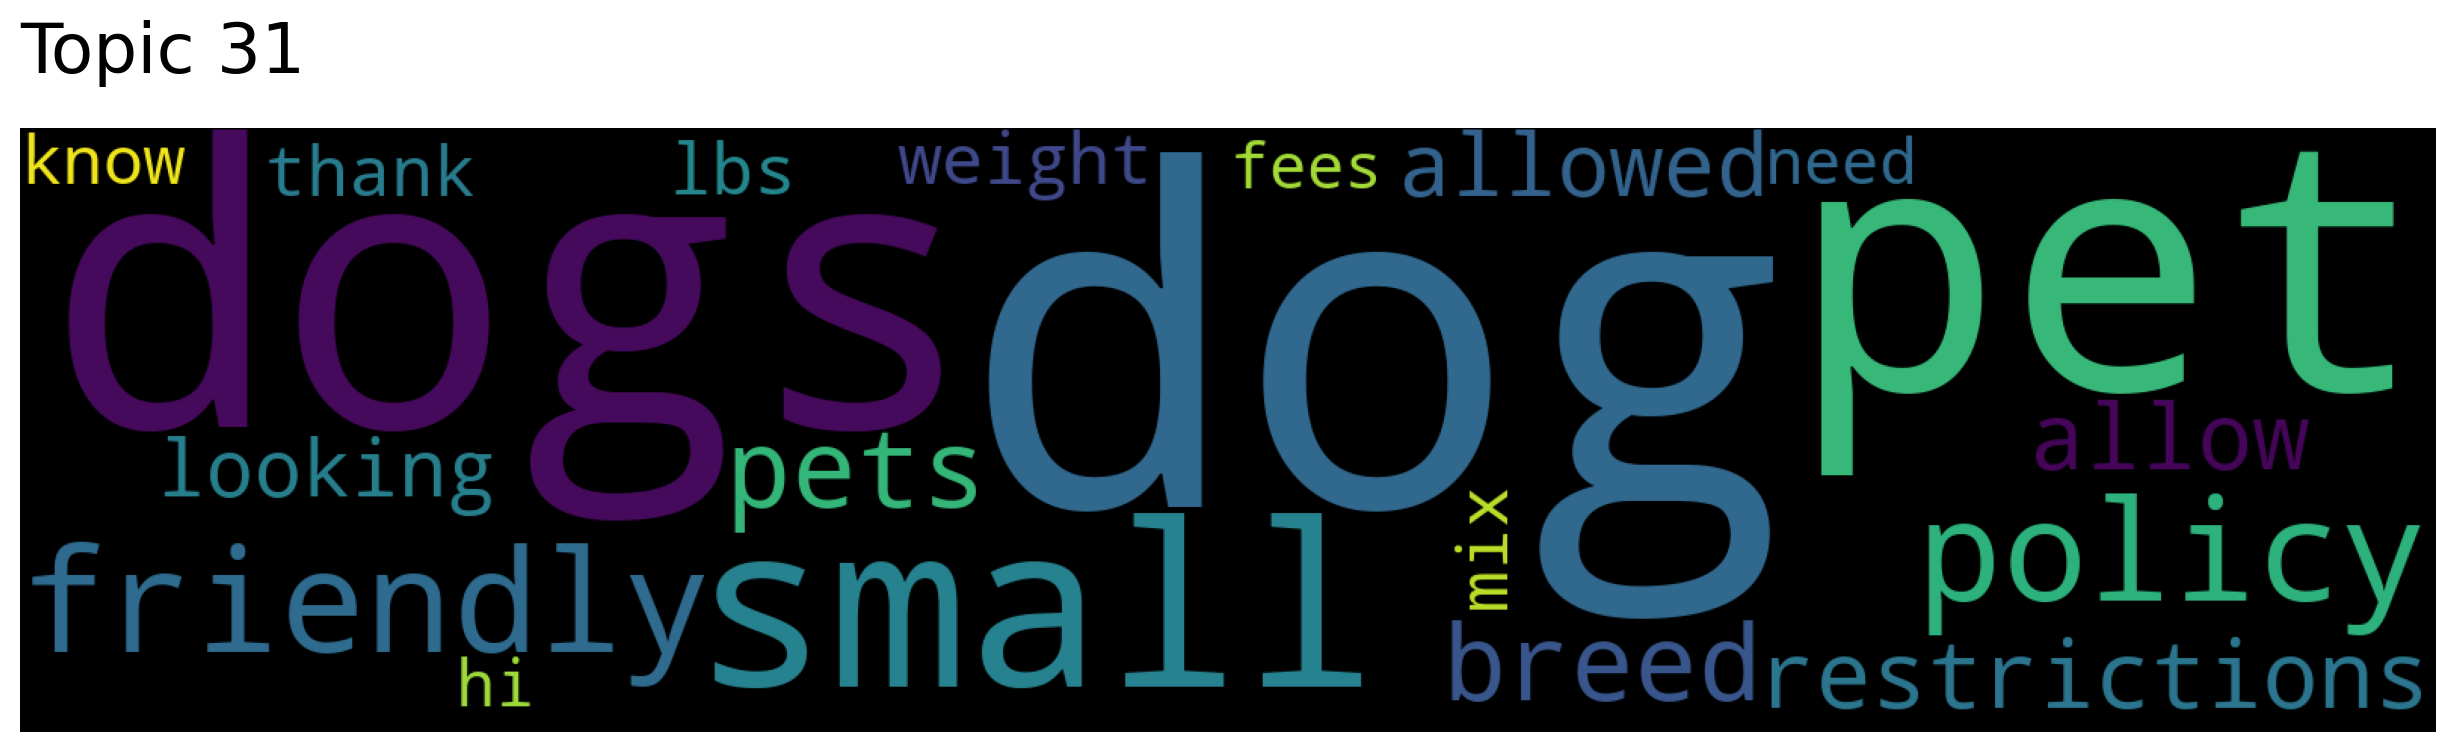

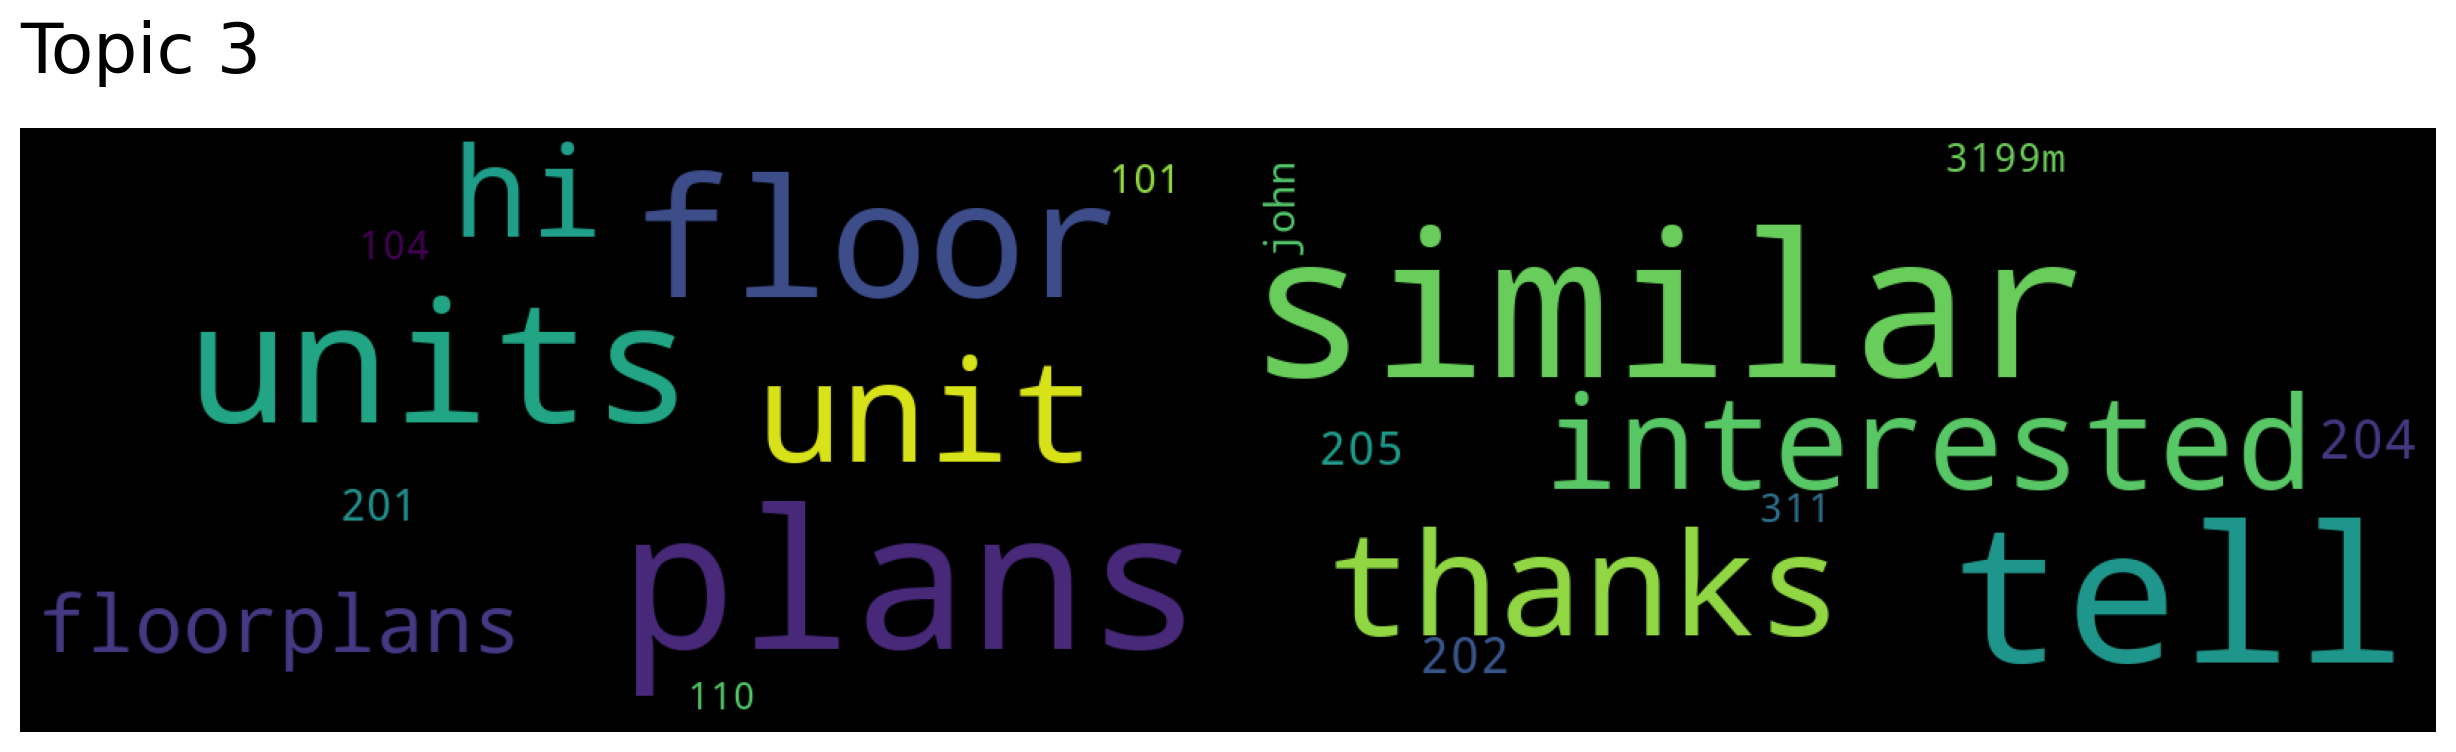

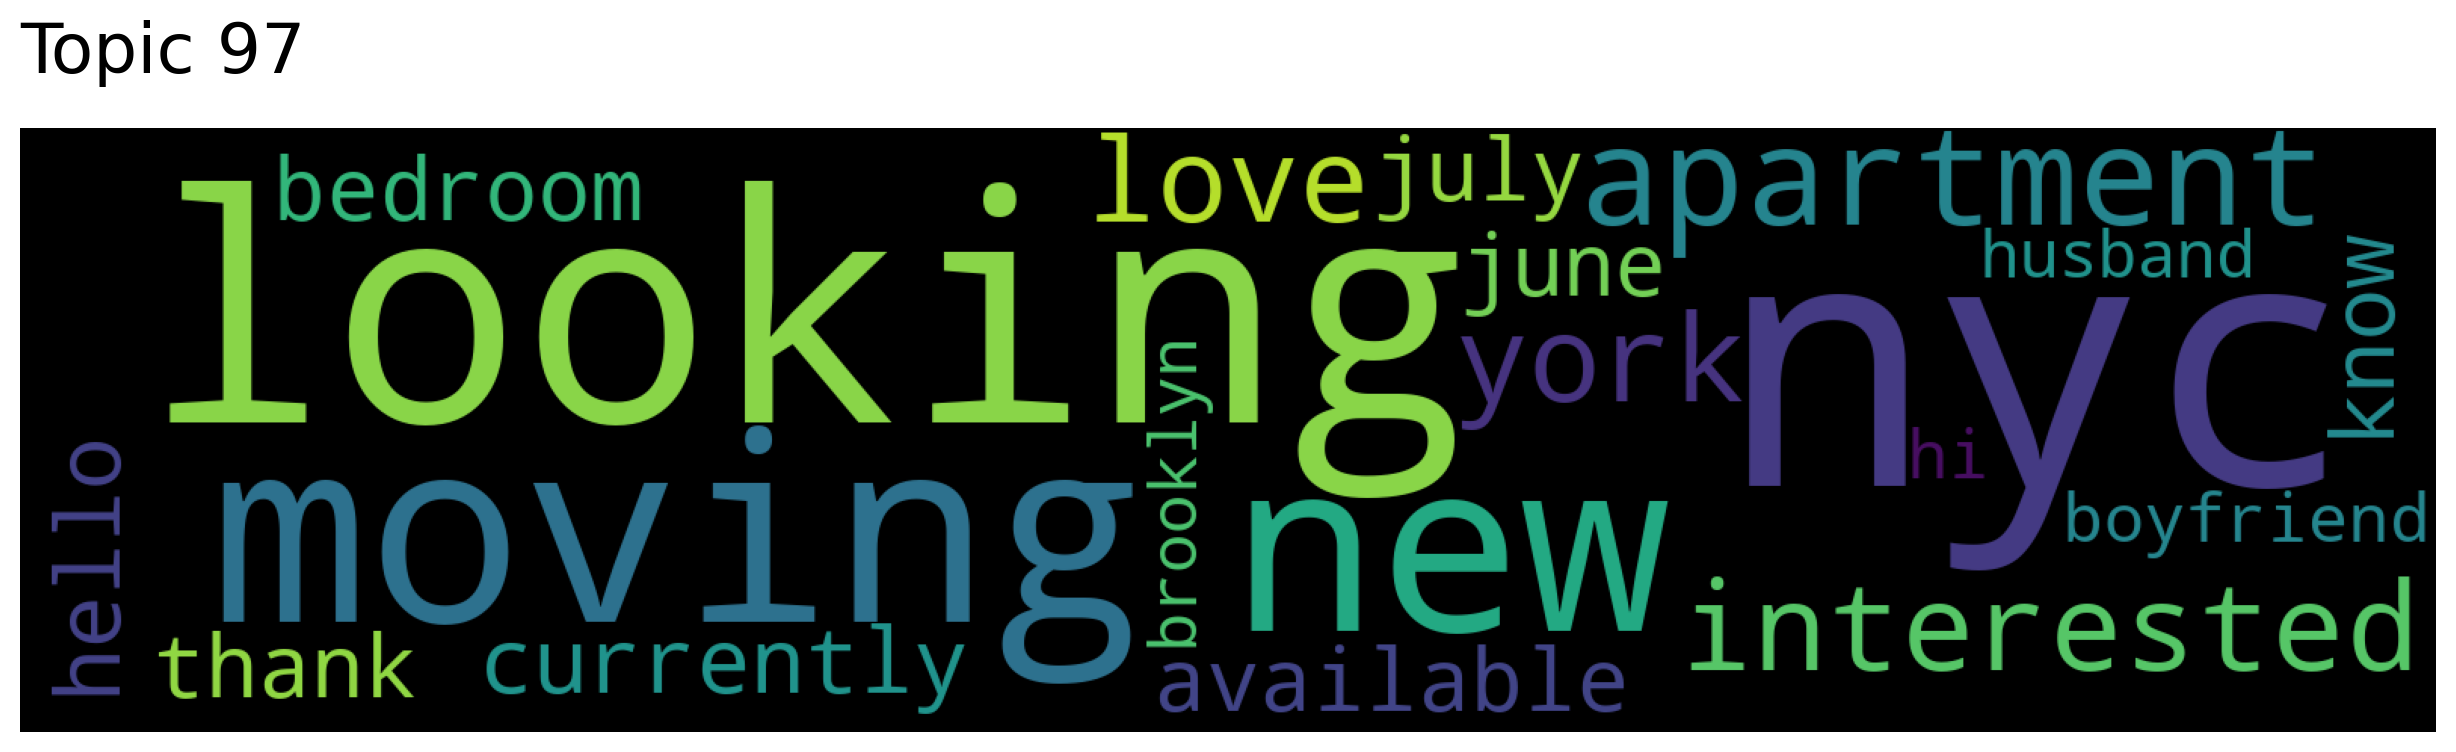

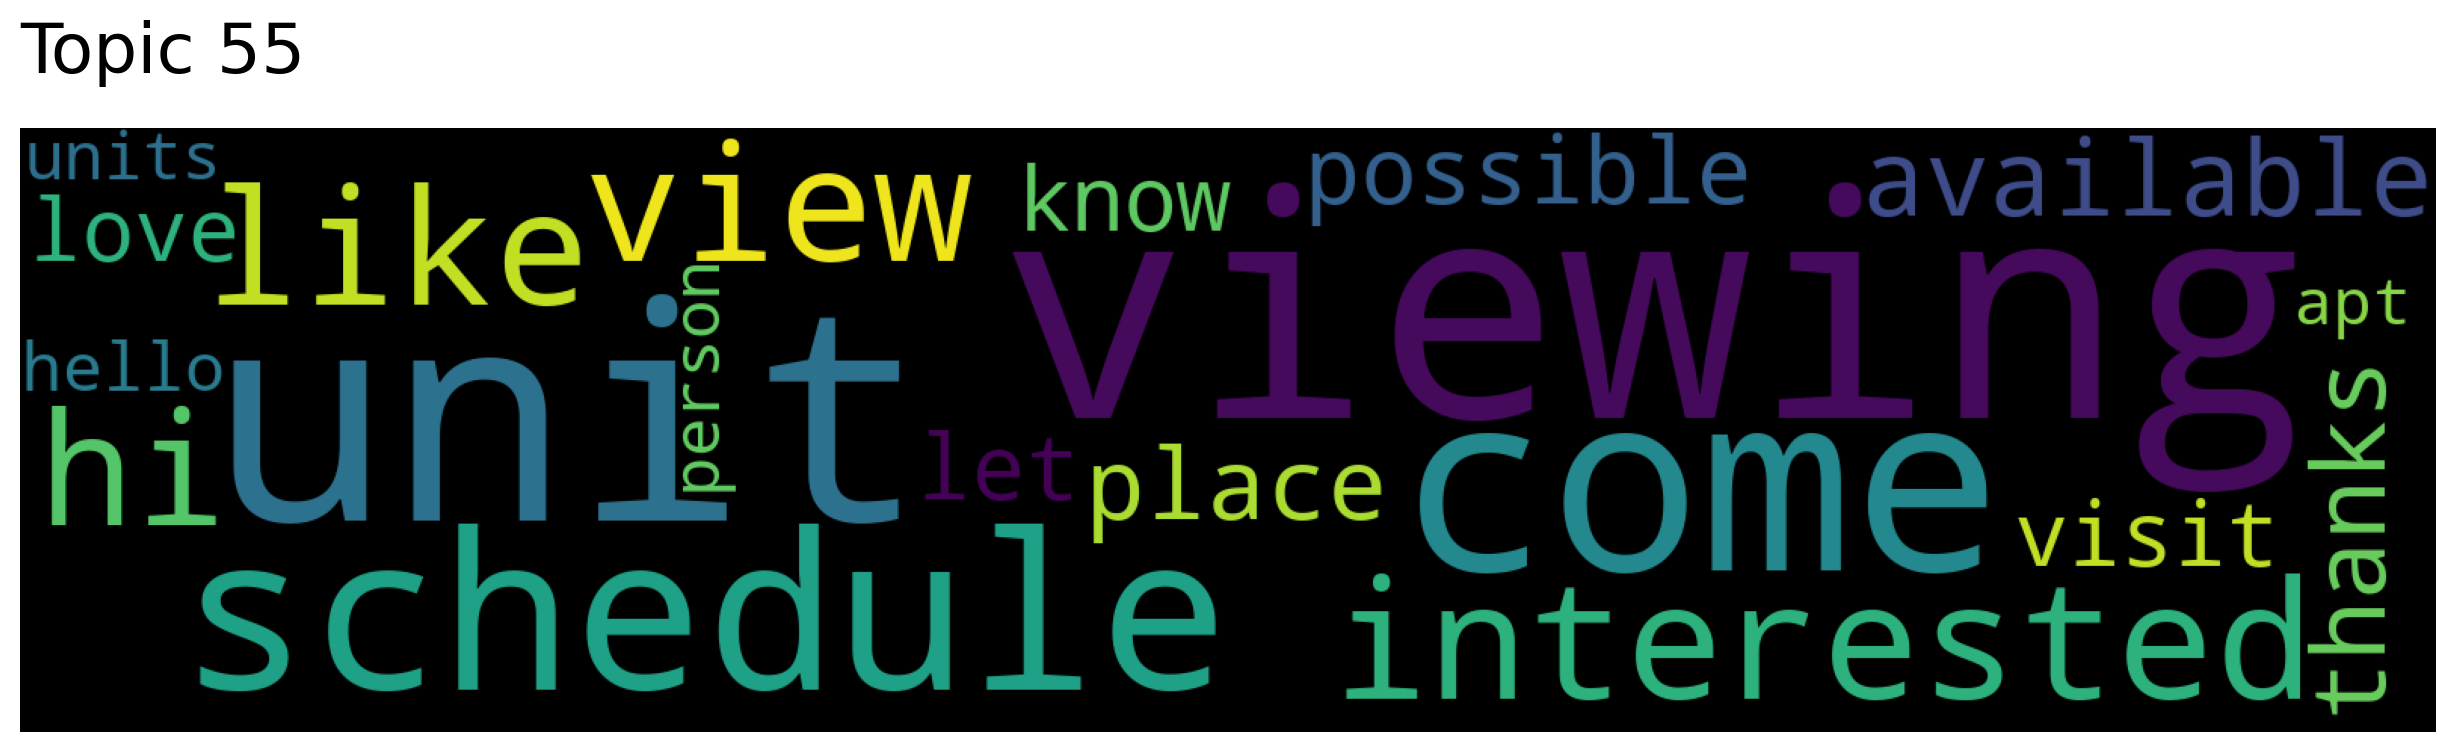

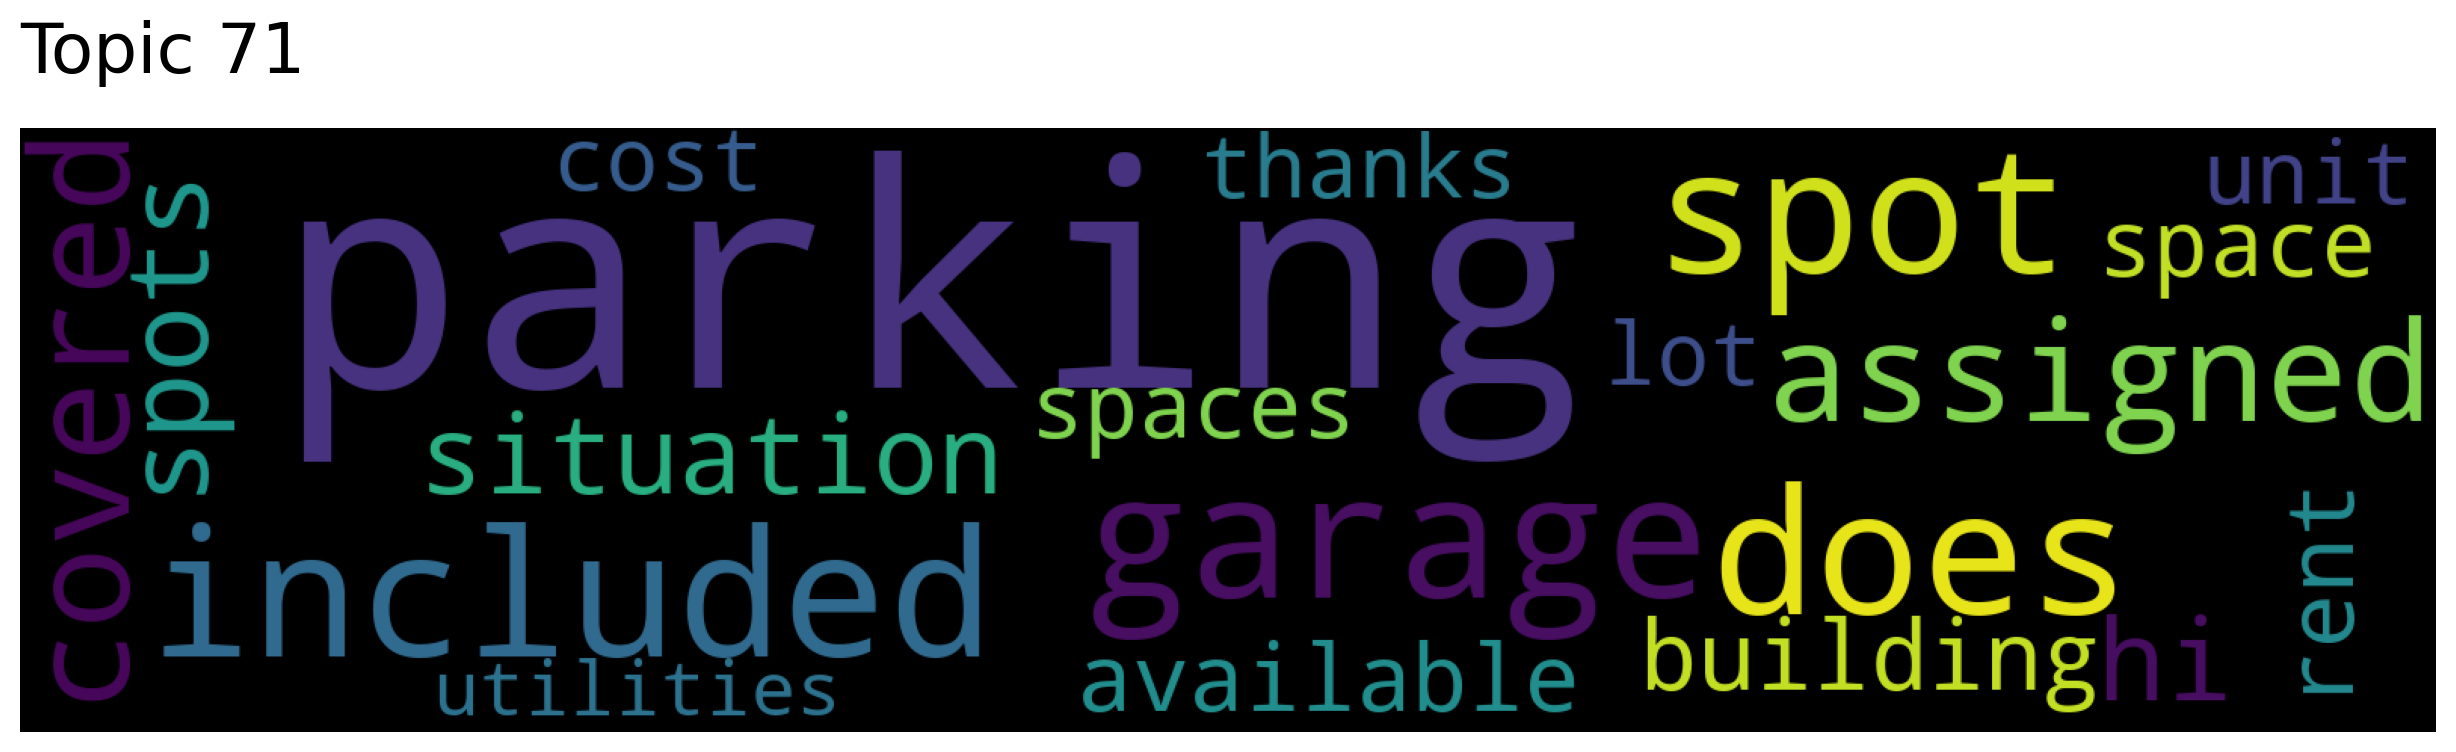

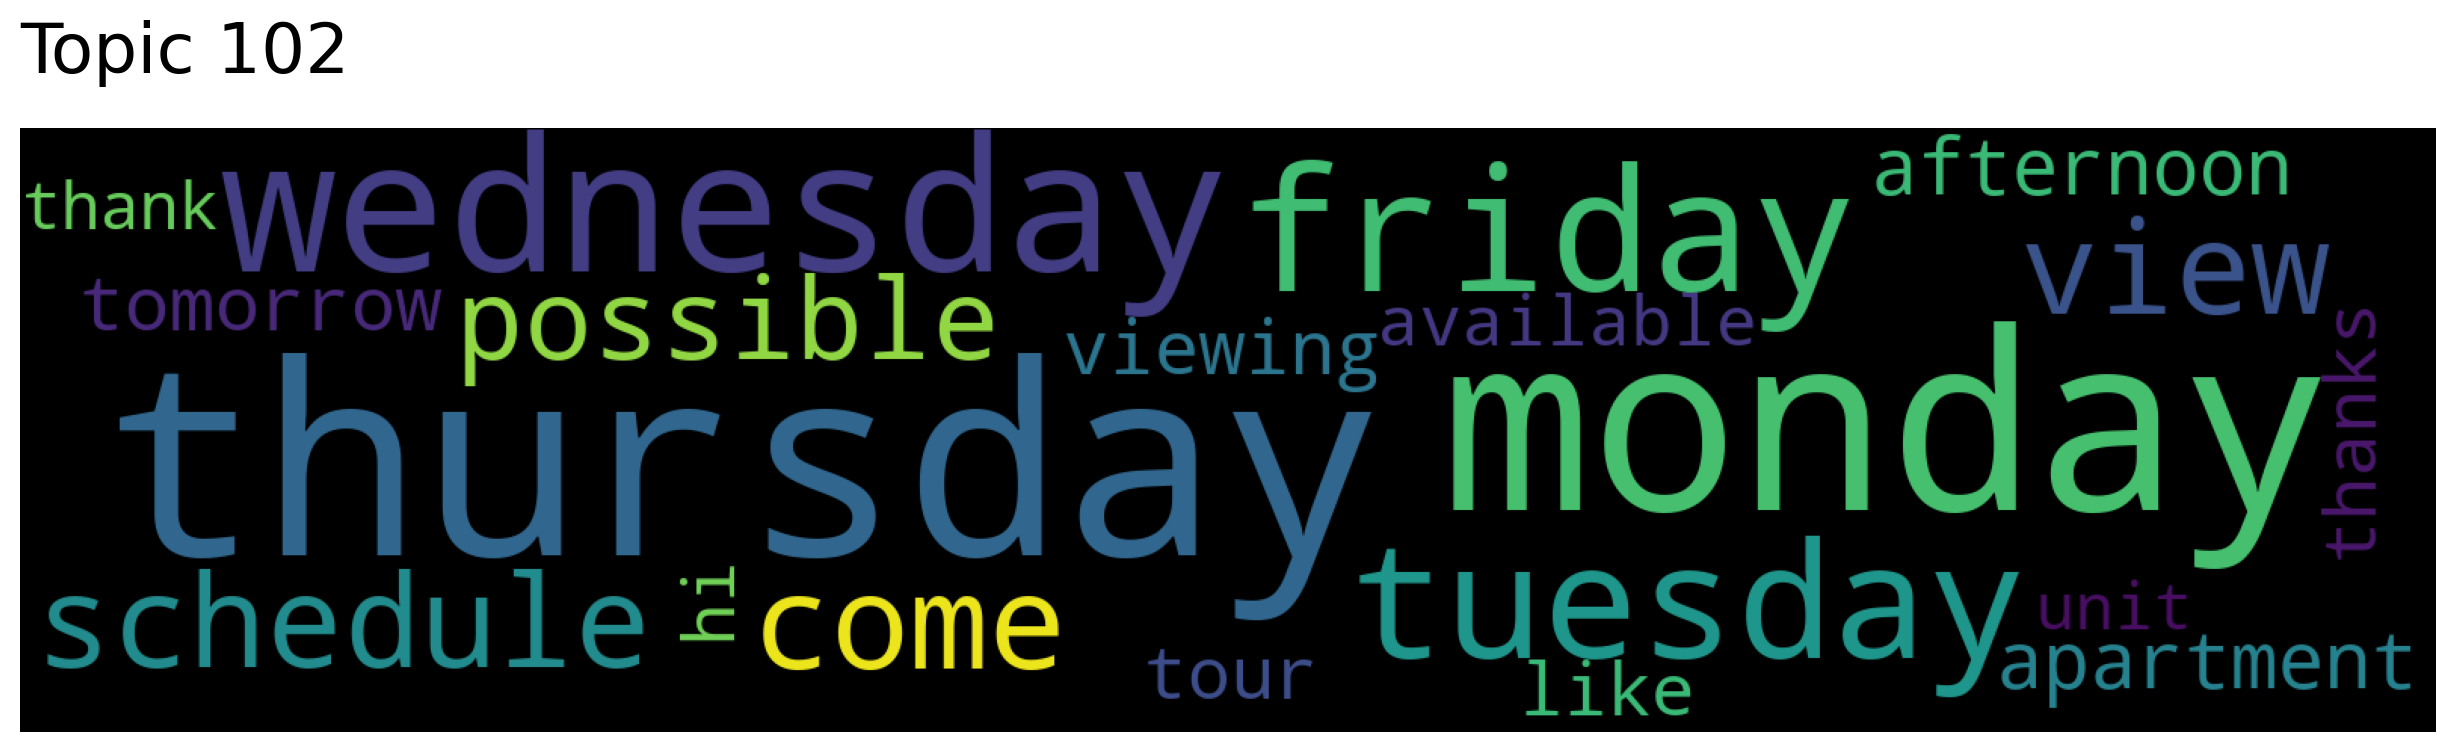

In [104]:
for topic in topic_sizes[1:(num_top_topics + 1)]['Topic']:
    word_score_dict = {word_score[0]: word_score[1] for word_score in top_n_words[topic]}
    plt.figure(figsize=(16, 4), dpi=200)
    plt.axis("off")
    plt.imshow(
        WordCloud(
            width=1600, height=400,
            background_color="black").generate_from_frequencies(word_score_dict))
    plt.title("Topic " + str(topic), loc='left', fontsize=25, pad=20)

Number of documents covered by top topics.

In [105]:
topic_sizes[1:]['Size'][:num_top_topics].sum()

30593

Look at some documents.

In [32]:
for text in docs_df[docs_df['Topic'] == 107]['Doc']:
    print(f"{text}\n====\n")

Hi, can you please tell me a little more about this apartment. I’m looking to moving in with others and we have a dog and a cat. The dog is a Rottweiler mix. Please let me know! Thank you!
====

Do you allow pets. We have an adult dog 6years old?
====

Hi there! I’m looking for a furnished apartment to stay in while I’m waiting for construction to finish on my new condo. I’ll have my small, well-behaved dog with me. My budget is $1,200-$1,800 per month. Thanks for your help!
====

Immediate 
$3500
Small dog
====

Are pets ok? Is storage available
====

Hello Verenice! Is this property pet friendly and section 8 approved?
====

I have 4 dogs and looking for big dog friendly apartments
====

My dog is a black lab. He's a good boy.
====

Hi, I am looking for a studio or 1 bedroom. I have a dog (Golden retriever).I expect to move in no later than 05/10. I am looking for a short term lease, prefer to end earlier than February 2021. Can you send me a quote please?
====

Hello Mamidyala Sindh


I don't think there's any deciding factors, for the most part it seems like your community had just about everything we want. I actually did have a couple questions though.
 1. Do you have an off leash dog park 
2. Is the community gated? 
3. Is there assigned parking 
4. Does a washer & dryer come
In every unit? 

Thank you so much!
====

I need a 2 bedroom and have a small dog.
====

Looking for a two bedroom for two couples to live in. We have a small dog.
====

How much would it be 2bed/2bath with two small dogs?
====

Hello- What is the pet policy here? If dog friendly and available to see this weekend, my husband and I are very interested. Please email me at sallielong@gmail.com
====

Hello yes I had a few questions-
Which, if any utilities are included/allocated?
What do you have available in studio/1 bedroom?
Also what is your pet policy like
====

My name is Hayley Holmes and I have been approved for a lease with your complex. However, my lease lists me as having a "pet" and 

Conclusion: Topics are very targeted, but they don't catch a lot.